In [ ]:
import os
import random
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
import meerkat as mk
from domino import DominoSlicer
from classifer import *
from bootstrap_utils import *
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from huggingface_hub import login



### Data Preparation

In [14]:
label_1_values =0
attribute =True

In [15]:
label_1 = "Pneumothorax"
label_2 ="Support Devices"
test_df = pd.read_parquet('test_df_with_embeddings.parquet')
print("Loading test and train DataFrames...")
train_df = pd.read_csv("/vol/bitbucket/yl28218/thesis/mimic_cxr_exp/data/train_df.csv")
# train_df_0 = train_df[train_df["Pneumothorax"] == 0]
# train_df_1 = train_df[train_df["Pneumothorax"] == 1]
print("Create the embeddings for the test DataFrame...")
test_df["combined_embedding"] = get_combined_embedding(test_df, 'image_embedding', 'report_embedding', n_components=512)
test_df["combined_emebdding_v2"] = get_combined_embedding(test_df, 'image_embedding', 'report_embedding', 'metadata_embedding', 512)
test_df["combined_embedding_v3"] = get_combined_embedding(test_df, 'report_embedding', 'metadata_embedding', n_components=512)
test_df["combined_embedding_v4"] = get_combined_embedding(test_df, 'image_embedding', 'metadata_embedding')
root_folder = "/vol/bitbucket/yl28218/thesis/physionet.org/files/mimic-cxr-jpg/2.1.0/files"
selected_columns = ['Support Devices', 'predicted', 'true', 'id', 'path', 'report_text', 'image_embedding', 'report_embedding', 'metadata_embedding', "Rows", "Columns", "metadata_description", "combined_embedding", "combined_emebdding_v2", "combined_embedding_v3", "combined_embedding_v4"]
checkpointpath = None
token_results = {"image_only": [], "image_text": [], "image_text_meta": [], "text": [], "meta": [], "report_metadata": [], "image_metadata": []}

bootstrap_times = 300


seed =42
k = 10
max_features = 1000

threshold = 0.1

        

Loading test and train DataFrames...
Create the embeddings for the test DataFrame...


In [10]:
test_results_3 = pd.read_parquet("/vol/bitbucket/yl28218/thesis/mimic_cxr_exp/results/exp1/test_results_exp1.parquet")

### Classifier Training 

In [17]:
label_1 = 'Pneumothorax'
label_2 = 'Support Devices'
attr= True
corr = 0.7
while  True:
    print(f"Target correlation for this iteration: {corr:.2f}")
    # Subsample the training DataFrame to achieve the desired correlation
    train = subsample_with_correlation(train_df, 'Pneumothorax', 'Support Devices', target_corr=corr, sample_size=1000, seed=seed)

    # test_df_support = test_df[test_df['Support Devices'] == 1].copy()
    # test_df_no_support = test_df[test_df['Support Devices'] == 0].copy()

    # test_support = test_df_support.sample(n=150, random_state=seed).reset_index(drop=True)
    # test_no_support = test_df_no_support.sample(n=150, random_state=seed).reset_index(drop=True)
    # test = pd.concat([test_support, test_no_support], ignore_index=True)

    #test = test_df.sample(n=300, random_state=seed).reset_index(drop=True)
    #only 10% of the test set has support devices and pneumothorax is 0
    test_df_sp_label1 = test_df[(test_df['Support Devices'] == 1) & (test_df['Pneumothorax'] == 0)].copy()
    test_1 = test_df_sp_label1.sample(n=60, random_state=42).reset_index(drop=True)
    print(f"Number of test samples with support devices: {len(test_1)}")
    # all the other test samples except those with support devices and pneumothorax 0
    test_df_rest = test_df[(test_df['Support Devices'] != 1) | (test_df['Pneumothorax'] != 0)].copy()
    test_2 = test_df_rest.sample(n=240, random_state=42).reset_index(drop=True)
    print(f"Number of test samples without support devices: {len(test_2)}")

    test = pd.concat([test_1, test_2], ignore_index=True)
    test = test.sample(frac=1, random_state=42).reset_index(drop=True)
    test['Support Devices'] = test['Support Devices'].fillna(0).astype(int)
    print(f"Total number of test samples: {len(test)}")


    #test = test_df.sample(n=300, random_state=seed).reset_index(drop=True)
    #val = test[test['Support Devices'] == 0].copy()
    # Ensure the validation set has no support devices, so the classifier is baised on the absence of support devices
    val = test[test['Support Devices'] != 1]

     #  Train the classifier
    print("Training the classifier...")
    best_acc, best_model, strength = train_model(train, val, root_folder, label_1, label_2, checkpointpath, epochs=10)


    
    
    if best_model is not None:
        test_results = evaluate_best_model(best_model, test, root_folder)
        if len(test_results) > 0:
            avg_test_acc = accuracy_score(test_results["true"], test_results["predicted"])
            print(f"Average Test Accuracy: {avg_test_acc:.4f}")
            test_results_1 = test_results[test_results["Pneumothorax"] == 0].copy()

            if label_2 in test_results.columns:
                support_mask = test_results_1[label_2] == 1
                if support_mask.sum() > 0:
                    support_acc = accuracy_score(test_results_1[support_mask]["true"], test_results_1[support_mask]["predicted"])
                    print(f" {label_2} X-ray Accuracy: {support_acc:.4f}")

                no_support_mask = test_results_1[label_2] != 1
                if no_support_mask.sum() > 0:
                    no_support_acc = accuracy_score(test_results_1[no_support_mask]["true"], test_results_1[no_support_mask]["predicted"])
                    print(f"No {label_2} X-ray Accuracy: {no_support_acc:.4f}")
        else:
            print("No test results to analyze.")
    else:
        print("No valid model trained.")

    print("Classifier training completed.")

    if no_support_acc - support_acc>= threshold:
        print(f"Support devices accuracy is significantly lower than no support devices accuracy by {no_support_acc - support_acc:.4f}, proceeding with analysis.")
        # Proceed with the analysis
        break

    else:
        print("The training was unsuccessful, skipping this iteration.")
        seed += 1
        continue 








Target correlation for this iteration: 0.70
Sampled subset with correlation ~ 0.703
Number of test samples with support devices: 60
Number of test samples without support devices: 240
Total number of test samples: 300
Training the classifier...
Loading cached complete file map...
Cache loaded successfully! Found 199501 pairs.
Filtering valid samples for train set...


100%|██████████| 1000/1000 [00:19<00:00, 50.68it/s]


Original train samples: 1000
Valid train samples: 851
Missing train samples: 149
Loading cached complete file map...
Cache loaded successfully! Found 199501 pairs.
Filtering valid samples for validation set...


100%|██████████| 177/177 [00:05<00:00, 33.53it/s]


Original validation samples: 177
Valid validation samples: 177
Missing validation samples: 0
========== Correlation Analysis =========
Correlation strength between Pneumothorax and Support Devices in clean train set): 0.722


Epoch 1/10: 100%|██████████| 107/107 [01:46<00:00,  1.00it/s]


Epoch 1 done. Avg Loss = 0.6680


Validating: 100%|██████████| 23/23 [00:21<00:00,  1.05it/s]


Val Accuracy: 0.2486


Epoch 2/10: 100%|██████████| 107/107 [01:39<00:00,  1.08it/s]


Epoch 2 done. Avg Loss = 0.6067


Validating: 100%|██████████| 23/23 [00:21<00:00,  1.05it/s]


Val Accuracy: 0.3842


Epoch 3/10: 100%|██████████| 107/107 [01:42<00:00,  1.04it/s]


Epoch 3 done. Avg Loss = 0.5588


Validating: 100%|██████████| 23/23 [00:21<00:00,  1.08it/s]


Val Accuracy: 0.5932


Epoch 4/10: 100%|██████████| 107/107 [01:39<00:00,  1.08it/s]


Epoch 4 done. Avg Loss = 0.5220


Validating: 100%|██████████| 23/23 [00:22<00:00,  1.02it/s]


Val Accuracy: 0.6497


Epoch 5/10: 100%|██████████| 107/107 [01:42<00:00,  1.04it/s]


Epoch 5 done. Avg Loss = 0.4387


Validating: 100%|██████████| 23/23 [00:19<00:00,  1.17it/s]


Val Accuracy: 0.6328


Epoch 6/10: 100%|██████████| 107/107 [01:56<00:00,  1.09s/it]


Epoch 6 done. Avg Loss = 0.4221


Validating: 100%|██████████| 23/23 [00:14<00:00,  1.60it/s]


Val Accuracy: 0.6328


Epoch 7/10: 100%|██████████| 107/107 [01:30<00:00,  1.18it/s]


Epoch 7 done. Avg Loss = 0.3479


Validating: 100%|██████████| 23/23 [00:14<00:00,  1.57it/s]

Val Accuracy: 0.6384
Early stopping triggered.


TypeError: evaluate_best_model() missing 1 required positional argument: 'label'

In [5]:
test_df_sp_label1 = test_df[(test_df['Support Devices'] == 1) & (test_df['Pneumothorax'] == 0)].copy()
test_1 = test_df_sp_label1.sample(n=30, random_state=42).reset_index(drop=True)
print(f"Number of test samples with support devices: {len(test_1)}")
# all the other test samples except those with support devices and pneumothorax 0
test_df_rest = test_df[(test_df['Support Devices'] != 1) | (test_df['Pneumothorax'] != 0)].copy()
test_2 = test_df_rest.sample(n=270, random_state=42).reset_index(drop=True)
print(f"Number of test samples without support devices: {len(test_2)}")

Number of test samples with support devices: 30
Number of test samples without support devices: 270


In [6]:
test_results.groupby(['Support Devices', 'Pneumothorax']).size().unstack(fill_value=0)

Pneumothorax,0.0,1.0
Support Devices,,
0,140,37
1,60,63


In [18]:
test_results = evaluate_best_model(best_model, test, root_folder, label_1)

Evaluating best model...
Loading cached complete file map...
Cache loaded successfully! Found 199501 pairs.
Filtering valid samples for test set...


100%|██████████| 300/300 [00:12<00:00, 23.29it/s]


Original test samples: 300
Valid test samples: 300
Missing test samples: 0


Testing: 100%|██████████| 38/38 [00:29<00:00,  1.28it/s]

Test Accuracy: 0.6367


In [19]:
test_results_1 = test_results[test_results['true'] != 1].copy()
test_results_1_support = test_results_1[test_results_1['Support Devices'] == 1].copy()
test_results_1_no_support = test_results_1[test_results_1['Support Devices'] != 1].copy()

# calculate the accuracy for the test results
test_results_1_support_acc = accuracy_score(test_results_1_support["true"], test_results_1_support["predicted"])
test_results_1_no_support_acc = accuracy_score(test_results_1_no_support["true"], test_results_1_no_support["predicted"])
print(f"Test results for support devices (1): {test_results_1_support_acc:.4f}")
print(f"Test results for no support devices (0): {test_results_1_no_support_acc:.4f}")

Test results for support devices (1): 0.4000
Test results for no support devices (0): 0.6714


### Domino

In [20]:
def domino_wrapper(mk_df, embeddings_col, targets_col, slice_name, pred_probs_col, seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    domino = DominoSlicer(
        y_log_likelihood_weight=10,
        y_hat_log_likelihood_weight=10,
        n_mixture_components=20,
        n_slices=5,
        random_state=seed,
        init_params="kmeans"
    )
    domino.fit(data=mk_df, embeddings=embeddings_col, targets=targets_col, pred_probs=pred_probs_col)
    mk_df[slice_name] = domino.predict_proba(data=mk_df, embeddings=embeddings_col, targets=targets_col, pred_probs=pred_probs_col)
    return mk_df

In [21]:
mk_df = create_meerkat_datapanel(test_results, selected_columns)
mk_df = domino_wrapper(mk_df, 'image_embedding', 'true', 'slice_image_only', 'predicted')
mk_df = domino_wrapper(mk_df, 'combined_embedding', 'true', 'slice_image_text', 'predicted')
mk_df = domino_wrapper(mk_df, 'combined_emebdding_v2', 'true', 'slice_image_text_meta', 'predicted')
mk_df = domino_wrapper(mk_df, "report_embedding", 'true', 'slice_report_text', 'predicted')
mk_df = domino_wrapper(mk_df, "metadata_embedding", 'true', 'slice_metadata', 'predicted')
mk_df = domino_wrapper(mk_df, "combined_embedding_v3", 'true', 'slice_report_metadata', 'predicted')
mk_df = domino_wrapper(mk_df, "combined_embedding_v4", 'true', 'slice_image_metadata', 'predicted')

slice_1, precision_k_1 = best_precision_slice('slice_image_only', mk_df, label_2, label_1_values, k, attribute)
slice_2, precision_k_2 = best_precision_slice('slice_image_text', mk_df, label_2, label_1_values, k, attribute)
slice_3, precision_k_3 = best_precision_slice('slice_image_text_meta', mk_df, label_2, label_1_values, k, attribute)
slice_4, precision_k_4 = best_precision_slice('slice_report_text', mk_df, label_2, label_1_values, k, attribute)
slice_5, precision_k_5 = best_precision_slice('slice_metadata', mk_df, label_2, label_1_values, k, attribute)
slice_6, precision_k_6 = best_precision_slice('slice_report_metadata', mk_df, label_2, label_1_values, k, attribute)
slice_7, precision_k_7 = best_precision_slice('slice_image_metadata', mk_df, label_2, label_1_values, k, attribute)


print(f"Precision@{k} for Image Only Slice: {precision_k_1:.4f}")
print(f"Precision@{k} for Image + Text Slice: {precision_k_2:.4f}")
print(f"Precision@{k} for Image + Text + Metadata Slice: {precision_k_3:.4f}")
print(f"Precision@{k} for Report Text Slice: {precision_k_4:.4f}")
print(f"Precision@{k} for Metadata Slice: {precision_k_5:.4f}")
print(f"Precision@{k} for Report + Metadata Slice: {precision_k_6:.4f}")
print(f"Precision@{k} for Image + Metadata Slice: {precision_k_7:.4f}")


tokens_slice_1 = analyze_error_slice_tokens(slice_1, test_results, k, max_features)
tokens_slice_2 = analyze_error_slice_tokens(slice_2, test_results, k, max_features)
tokens_slice_3 = analyze_error_slice_tokens(slice_3, test_results, k, max_features)
tokens_slice_4 = analyze_error_slice_tokens(slice_4, test_results, k, max_features)
tokens_slice_5 = analyze_error_slice_tokens(slice_5, test_results, k, max_features)
tokens_slice_6 = analyze_error_slice_tokens(slice_6, test_results, k, max_features)
tokens_slice_7 = analyze_error_slice_tokens(slice_7, test_results, k, max_features)

 12%|█▏        | 12/100 [00:00<00:00, 98.15it/s] 


Precision@10 for Image Only Slice: 0.6000
Precision@10 for Image + Text Slice: 0.7000
Precision@10 for Image + Text + Metadata Slice: 0.9000
Precision@10 for Report Text Slice: 0.4000
Precision@10 for Metadata Slice: 0.8000
Precision@10 for Report + Metadata Slice: 1.0000
Precision@10 for Image + Metadata Slice: 0.6000


In [20]:
def analyze_error_slice_tokens(slice_df, test_df, k=20, max_features=1000, seed=42):
    most_common_class = slice_df['true'].value_counts().idxmax()
    correct_df = test_df[(test_df['true'] == most_common_class) & (test_df['predicted'] == most_common_class)]

    error_texts = (slice_df['report_text'].fillna('') + ' ' + slice_df['metadata_description'].fillna('')).tolist()
    normal_texts = (correct_df['report_text'].fillna('') + ' ' + correct_df['metadata_description'].fillna('')).tolist()
    all_texts = normal_texts + error_texts
    vectorizer = TfidfVectorizer(
        max_features=max_features,
        ngram_range=(1, 4),
        stop_words="english",
        token_pattern=r'\b[a-zA-Z]{2,}\b'
    )
    tfidf_matrix = vectorizer.fit_transform(all_texts)
    feature_names = vectorizer.get_feature_names_out()
    split_index = len(normal_texts)
    tfidf_array = tfidf_matrix.toarray()
    normal_avg = np.mean(tfidf_array[:split_index], axis=0)
    error_avg = np.mean(tfidf_array[split_index:], axis=0)
    diff_scores = error_avg - normal_avg
    #diff_scores = np.abs(error_avg - normal_avg)
    analyzer = vectorizer.build_analyzer()
    error_tokens = sum((analyzer(t) for t in error_texts), [])
    normal_tokens = sum((analyzer(t) for t in normal_texts), [])
    error_counts = Counter(error_tokens)
    normal_counts = Counter(normal_tokens)
    result_df = pd.DataFrame({
        'token': feature_names,
        'diff_score': diff_scores,
        'error_count': [error_counts[token] for token in feature_names],
        'normal_count': [normal_counts[token] for token in feature_names]
    })
    return result_df.sort_values(by='diff_score', ascending=False)

In [21]:

tokens_slice_1 = analyze_error_slice_tokens(slice_1, test_results, k, max_features)
tokens_slice_2 = analyze_error_slice_tokens(slice_2, test_results, k, max_features)
tokens_slice_3 = analyze_error_slice_tokens(slice_3, test_results, k, max_features)
tokens_slice_4 = analyze_error_slice_tokens(slice_4, test_results, k, max_features)
tokens_slice_5 = analyze_error_slice_tokens(slice_5, test_results, k, max_features)
tokens_slice_6 = analyze_error_slice_tokens(slice_6, test_results, k, max_features)
tokens_slice_7 = analyze_error_slice_tokens(slice_7, test_results, k, max_features)

In [25]:
tokens_slice_1.head()

,token,diff_score,error_count,normal_count
932,tube,0.036510,20,35
916,tavr,0.030769,5,0
44,aspiration,0.028223,8,9
668,portable,0.027333,40,122
541,mild pulmonary edema,0.027243,8,4


In [23]:
tokens_slice_2.head()

,token,diff_score,error_count,normal_count
653,portable,0.024955,96,115
693,posterior view patient upright,0.016748,55,60
291,examination performed anterior posterior,0.016355,55,61
379,hours examination performed anterior,0.016355,55,61
691,posterior view,0.016355,55,61


In [24]:
tokens_slice_3.head()

,token,diff_score,error_count,normal_count
461,left,0.061346,25,86
927,tube,0.052199,13,37
673,portable,0.048111,28,115
90,catheter,0.045096,7,13
645,placement,0.042300,6,9


In [25]:
tokens_slice_4.head()

,token,diff_score,error_count,normal_count
660,portable,0.037949,35,115
120,chest portable,0.037386,17,38
121,chest portable ap,0.037386,17,38
661,portable ap,0.032995,18,46
24,ap,0.032696,23,64


In [26]:
tokens_slice_5.head()

,token,diff_score,error_count,normal_count
928,tube,0.051291,26,37
386,ij catheter,0.030447,5,0
820,right ij catheter,0.030447,5,0
385,ij,0.028268,7,5
86,catheter,0.027667,11,13


In [27]:
tokens_slice_6.head()

,token,diff_score,error_count,normal_count
923,tip,0.062503,14,10
925,tube,0.060883,20,37
487,line,0.053324,12,10
23,ap chest,0.037425,11,20
912,tavr,0.035173,4,1


In [28]:
tokens_slice_7.head()

,token,diff_score,error_count,normal_count
933,tube,0.049854,24,37
493,line,0.048496,12,10
636,placement,0.037246,8,9
447,jugular,0.033106,7,6
424,internal jugular,0.031757,6,4


In [29]:
# find the
analyze_error_slice_tokens(test_results, test_results, k, max_features).head(20)

,token,diff_score,error_count,normal_count
30,apical,0.019471,84,3
31,apical pneumothorax,0.016359,66,2
455,left,0.016278,369,86
929,tube,0.016204,185,37
812,right,0.015671,498,125
813,right apical,0.012024,44,2
701,ptx,0.010939,53,7
814,right apical pneumothorax,0.010549,39,2
152,chest tube,0.010011,80,16
84,catheter,0.009584,73,13


In [30]:
# the samples with wrong predictions
test_results_incorrect = test_results[test_results['true'] != test_results['predicted']].copy()
# calculate the suppoting devices proportion
test_results_incorrect['Support Devices'] = test_results_incorrect['Support Devices'].fillna(0)
# if support devices not equal to 1, then 0
test_results_incorrect['Support Devices'] = [1 if x == 1 else 0 for x in test_results_incorrect['Support Devices']]
support_devices_count = test_results_incorrect['Support Devices'].sum()
total_count = len(test_results_incorrect)
support_devices_proportion = support_devices_count / total_count if total_count > 0 else 0
print(f"Support Devices Proportion in Incorrect Predictions: {support_devices_proportion:.4f}")

Support Devices Proportion in Incorrect Predictions: 0.3835


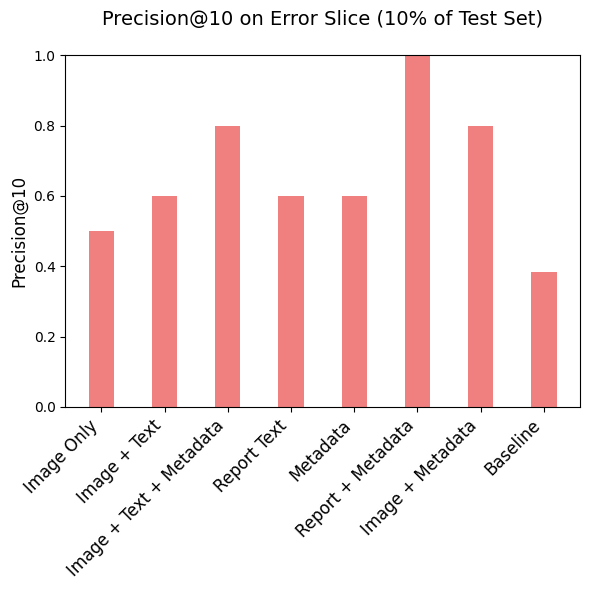

In [31]:
import matplotlib.pyplot as plt


k = 10
precision_values = [
    precision_k_1,
    precision_k_2,
    precision_k_3,
    precision_k_4,
    precision_k_5,
    precision_k_6,
    precision_k_7,
    support_devices_proportion
]

embedding_types = [
    "Image Only",
    "Image + Text",
    "Image + Text + Metadata",
    "Report Text",
    "Metadata",
    "Report + Metadata",
    "Image + Metadata",
    "Baseline"
    
]

plt.figure(figsize=(6, 6))
bars = plt.bar(embedding_types, precision_values, color="lightcoral",width=0.4)

# for bar, value in zip(bars, precision_values):
#     plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
#              f"{value:.4f}", ha='center', va='bottom', fontsize=12)

plt.title(
    f"Precision@{k} on Error Slice (10% of Test Set)\n",
    fontsize=14
)
plt.ylabel(f"Precision@{k}", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.ylim(0, 1)  
plt.tight_layout()
plt.show()


In [32]:
test_df_sp_label1 = test_df[(test_df['Support Devices'] == 1) & (test_df['Pneumothorax'] == 0)].copy()
test_1 = test_df_sp_label1.sample(n=15, random_state=42).reset_index(drop=True)
print(f"Number of test samples with support devices: {len(test_1)}")
# all the other test samples except those with support devices and pneumothorax 0
test_df_rest = test_df[(test_df['Support Devices'] != 1) | (test_df['Pneumothorax'] != 0)].copy()
test_2 = test_df_rest.sample(n=285, random_state=42).reset_index(drop=True)
print(f"Number of test samples without support devices: {len(test_2)}")

test = pd.concat([test_1, test_2], ignore_index=True)
test = test.sample(frac=1, random_state=42).reset_index(drop=True)
test['Support Devices'] = test['Support Devices'].fillna(0).astype(int)
print(f"Total number of test samples: {len(test)}")

Number of test samples with support devices: 15
Number of test samples without support devices: 285
Total number of test samples: 300


In [33]:
test.groupby(['Support Devices', 'true']).size().unstack(fill_value=0)

true,0,1
Support Devices,,
0,167,47
1,15,71


In [40]:
label_1 = 'Pneumothorax'
test_results_2 = evaluate_best_model(best_model, test, root_folder, label_1)

Evaluating best model...
Loading cached complete file map...
Cache loaded successfully! Found 199501 pairs.
Filtering valid samples for test set...


100%|██████████| 300/300 [00:08<00:00, 36.65it/s]


Original test samples: 300
Valid test samples: 300
Missing test samples: 0


Testing: 100%|██████████| 38/38 [00:18<00:00,  2.08it/s]

Test Accuracy: 0.5800


In [ ]:
test_results_1 = test_results_2[test_results_2['true'] != 1].copy()
test_results_1_support = test_results_1[test_results_1['Support Devices'] == 1].copy()
test_results_1_no_support = test_results_1[test_results_1['Support Devices'] != 1].copy()   
# calculate the accuracy for the test results
test_results_1_support_acc = accuracy_score(test_results_1_support["true"], test_results_1_support["predicted"])
test_results_1_no_support_acc = accuracy_score(test_results_1_no_support["true"], test_results_1_no_support["predicted"])
print(f"Test results for support devices (1): {test_results_1_support_acc:.4f}")
print(f"Test results for no support devices (0): {test_results_1_no_support_acc:.4f}")

In [42]:
mk_df = create_meerkat_datapanel(test_results_2, selected_columns)
mk_df = domino_wrapper(mk_df, 'image_embedding', 'true', 'slice_image_only', 'predicted')
mk_df = domino_wrapper(mk_df, 'combined_embedding', 'true', 'slice_image_text', 'predicted')
mk_df = domino_wrapper(mk_df, 'combined_emebdding_v2', 'true', 'slice_image_text_meta', 'predicted')
mk_df = domino_wrapper(mk_df, "report_embedding", 'true', 'slice_report_text', 'predicted')
mk_df = domino_wrapper(mk_df, "metadata_embedding", 'true', 'slice_metadata', 'predicted')
mk_df = domino_wrapper(mk_df, "combined_embedding_v3", 'true', 'slice_report_metadata', 'predicted')
mk_df = domino_wrapper(mk_df, "combined_embedding_v4", 'true', 'slice_image_metadata', 'predicted')

slice_1, precision_k_1 = best_precision_slice('slice_image_only', mk_df, label_2, label_1_values, k, attribute)
slice_2, precision_k_2 = best_precision_slice('slice_image_text', mk_df, label_2, label_1_values, k, attribute)
slice_3, precision_k_3 = best_precision_slice('slice_image_text_meta', mk_df, label_2, label_1_values, k, attribute)
slice_4, precision_k_4 = best_precision_slice('slice_report_text', mk_df, label_2, label_1_values, k, attribute)
slice_5, precision_k_5 = best_precision_slice('slice_metadata', mk_df, label_2, label_1_values, k, attribute)
slice_6, precision_k_6 = best_precision_slice('slice_report_metadata', mk_df, label_2, label_1_values, k, attribute)
slice_7, precision_k_7 = best_precision_slice('slice_image_metadata', mk_df, label_2, label_1_values, k, attribute)


print(f"Precision@{k} for Image Only Slice: {precision_k_1:.4f}")
print(f"Precision@{k} for Image + Text Slice: {precision_k_2:.4f}")
print(f"Precision@{k} for Image + Text + Metadata Slice: {precision_k_3:.4f}")
print(f"Precision@{k} for Report Text Slice: {precision_k_4:.4f}")
print(f"Precision@{k} for Metadata Slice: {precision_k_5:.4f}")
print(f"Precision@{k} for Report + Metadata Slice: {precision_k_6:.4f}")
print(f"Precision@{k} for Image + Metadata Slice: {precision_k_7:.4f}")


tokens_slice_1 = analyze_error_slice_tokens(slice_1, test_results, k, max_features)
tokens_slice_2 = analyze_error_slice_tokens(slice_2, test_results, k, max_features)
tokens_slice_3 = analyze_error_slice_tokens(slice_3, test_results, k, max_features)
tokens_slice_4 = analyze_error_slice_tokens(slice_4, test_results, k, max_features)
tokens_slice_5 = analyze_error_slice_tokens(slice_5, test_results, k, max_features)
tokens_slice_6 = analyze_error_slice_tokens(slice_6, test_results, k, max_features)
tokens_slice_7 = analyze_error_slice_tokens(slice_7, test_results, k, max_features)

 19%|█▉        | 19/100 [00:00<00:00, 481.33it/s]


Precision@10 for Image Only Slice: 0.2000
Precision@10 for Image + Text Slice: 0.1000
Precision@10 for Image + Text + Metadata Slice: 0.2000
Precision@10 for Report Text Slice: 0.4000
Precision@10 for Metadata Slice: 0.4000
Precision@10 for Report + Metadata Slice: 0.1000
Precision@10 for Image + Metadata Slice: 0.2000


In [44]:
#the samples with wrong predictions
test_results_incorrect = test_results_2[test_results_2['true'] != test_results_2['predicted']].copy()
# calculate the suppoting devices proportion
test_results_incorrect['Support Devices'] = test_results_incorrect['Support Devices'].fillna(0)
# if support devices not equal to 1, then 0
test_results_incorrect['Support Devices'] = [1 if x == 1 else 0 for x in test_results_incorrect['Support Devices']]
support_devices_count = test_results_incorrect['Support Devices'].sum()
total_count = len(test_results_incorrect)
support_devices_proportion = support_devices_count / total_count if total_count > 0 else 0
print(f"Support Devices Proportion in Incorrect Predictions: {support_devices_proportion:.4f}")


Support Devices Proportion in Incorrect Predictions: 0.2063


In [45]:
def analyze_error_slice_tokens(slice_df, test_df, k=20, max_features=1000, seed=42):
    most_common_class = slice_df['true'].value_counts().idxmax()
    correct_df = test_df[(test_df['true'] == most_common_class) & (test_df['predicted'] == most_common_class)]

    error_texts = (slice_df['report_text'].fillna('') + ' ' + slice_df['metadata_description'].fillna('')).tolist()
    normal_texts = (correct_df['report_text'].fillna('') + ' ' + correct_df['metadata_description'].fillna('')).tolist()
    all_texts = normal_texts + error_texts
    vectorizer = TfidfVectorizer(
        max_features=max_features,
        ngram_range=(1, 4),
        stop_words="english",
        token_pattern=r'\b[a-zA-Z]{2,}\b'
    )
    tfidf_matrix = vectorizer.fit_transform(all_texts)
    feature_names = vectorizer.get_feature_names_out()
    split_index = len(normal_texts)
    tfidf_array = tfidf_matrix.toarray()
    normal_avg = np.mean(tfidf_array[:split_index], axis=0)
    error_avg = np.mean(tfidf_array[split_index:], axis=0)
    diff_scores = error_avg - normal_avg
    #diff_scores = np.abs(error_avg - normal_avg)
    analyzer = vectorizer.build_analyzer()
    error_tokens = sum((analyzer(t) for t in error_texts), [])
    normal_tokens = sum((analyzer(t) for t in normal_texts), [])
    error_counts = Counter(error_tokens)
    normal_counts = Counter(normal_tokens)
    result_df = pd.DataFrame({
        'token': feature_names,
        'diff_score': diff_scores,
        'error_count': [error_counts[token] for token in feature_names],
        'normal_count': [normal_counts[token] for token in feature_names]
    })
    return result_df.sort_values(by='diff_score', ascending=False)

In [46]:

tokens_slice_1 = analyze_error_slice_tokens(slice_1, test_results, k, max_features)
tokens_slice_2 = analyze_error_slice_tokens(slice_2, test_results, k, max_features)
tokens_slice_3 = analyze_error_slice_tokens(slice_3, test_results, k, max_features)
tokens_slice_4 = analyze_error_slice_tokens(slice_4, test_results, k, max_features)
tokens_slice_5 = analyze_error_slice_tokens(slice_5, test_results, k, max_features)
tokens_slice_6 = analyze_error_slice_tokens(slice_6, test_results, k, max_features)
tokens_slice_7 = analyze_error_slice_tokens(slice_7, test_results, k, max_features)

In [157]:
tokens_slice_1.head()

,token,diff_score,error_count,normal_count
725,ptx,0.060524,7,12
642,pigtail,0.044214,4,2
250,diffuse,0.040840,4,2
854,severe,0.039516,5,11
424,increasing,0.039151,4,5


In [158]:
tokens_slice_2.head()

,token,diff_score,error_count,normal_count
714,ptx,0.083388,7,12
624,pigtail,0.059748,4,2
662,portable,0.051259,19,173
562,obtained,0.049530,4,8
425,increasing,0.045662,3,5


In [159]:
tokens_slice_3.head()

,token,diff_score,error_count,normal_count
900,sp,0.033589,5,0
426,lavage,0.023199,3,0
536,normal,0.022977,14,18
668,pneumothorax pleural,0.021820,3,0
669,pneumothorax pleural effusion,0.021820,3,0


In [160]:
tokens_slice_4.head()

,token,diff_score,error_count,normal_count
268,emphysema,0.021798,8,2
517,mass,0.020156,6,1
658,pneumothorax pleural,0.017475,8,7
622,performed lateral view,0.016279,11,16
621,performed lateral,0.016279,11,16


In [161]:
tokens_slice_5.head()

,token,diff_score,error_count,normal_count
648,pneumomediastinum,0.038263,5,1
933,tube,0.038069,14,52
720,ptx,0.035409,6,12
246,dilation,0.035294,4,1
878,small,0.035251,16,46


In [162]:
tokens_slice_6.head()

,token,diff_score,error_count,normal_count
807,report indication,0.048733,5,18
349,final report indication,0.048733,5,18
350,final report indication year,0.044186,4,12
808,report indication year,0.044186,4,12
809,report indication year old,0.044186,4,12


In [163]:
tokens_slice_7.head()

,token,diff_score,error_count,normal_count
624,pigtail,0.073014,4,2
707,ptx,0.067069,5,12
800,removed,0.061487,4,11
255,emphysema,0.060352,3,2
286,evidence,0.057375,8,43


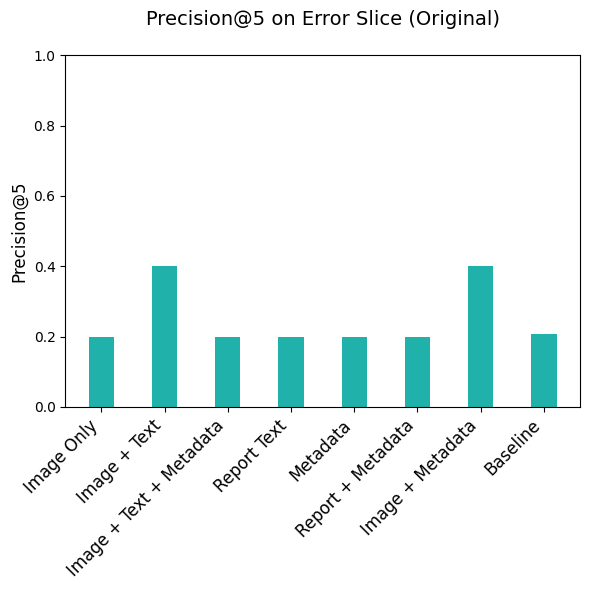

In [19]:
from matplotlib import pyplot as plt
k = 5
precision_values = [
    precision_k_1,
    precision_k_2,
    precision_k_3,
    precision_k_4,
    precision_k_5,
    precision_k_6,
    precision_k_7,
    support_devices_proportion
]

embedding_types = [
    "Image Only",
    "Image + Text",
    "Image + Text + Metadata",
    "Report Text",
    "Metadata",
    "Report + Metadata",
    "Image + Metadata",
    "Baseline"
    
]

plt.figure(figsize=(6, 6))
bars = plt.bar(embedding_types, precision_values, color="lightseagreen",width=0.4)

# for bar, value in zip(bars, precision_values):
#     plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
#              f"{value:.4f}", ha='center', va='bottom', fontsize=12)

plt.title(
    f"Precision@{k} on Error Slice (Original)\n",
    fontsize=14
)
plt.ylabel(f"Precision@{k}", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.ylim(0, 1)  
plt.tight_layout()
plt.show()

In [49]:
#save the results to  parquet files
output_dir = "/vol/bitbucket/yl28218/thesis/mimic_cxr_exp/results/exp1"
if not os.path.exists(output_dir):  
    os.makedirs(output_dir)
test_results_2.to_parquet(os.path.join(output_dir, "test_results_exp1.parquet"), index=False)


In [165]:
test_df_sp_label1 = test_df[(test_df['Support Devices'] == 1) & (test_df['Pneumothorax'] == 0)].copy()
test_1 = test_df_sp_label1.sample(n=60, random_state=42).reset_index(drop=True)
print(f"Number of test samples with support devices: {len(test_1)}")
# all the other test samples except those with support devices and pneumothorax 0
test_df_rest = test_df[(test_df['Support Devices'] != 1) | (test_df['Pneumothorax'] != 0)].copy()
test_2 = test_df_rest.sample(n=240, random_state=42).reset_index(drop=True)
print(f"Number of test samples without support devices: {len(test_2)}")

test = pd.concat([test_1, test_2], ignore_index=True)
test = test.sample(frac=1, random_state=42).reset_index(drop=True)
test['Support Devices'] = test['Support Devices'].fillna(0).astype(int)
print(f"Total number of test samples: {len(test)}")

Number of test samples with support devices: 60
Number of test samples without support devices: 240
Total number of test samples: 300


In [166]:
test_results_3 = evaluate_best_model(best_model, test, root_folder)

Evaluating best model...
Loading cached complete file map...
Cache loaded successfully! Found 199501 pairs.
Filtering valid samples for test set...


100%|██████████| 300/300 [00:09<00:00, 31.46it/s]


Original test samples: 300
Valid test samples: 300
Missing test samples: 0


Testing: 100%|██████████| 38/38 [00:14<00:00,  2.59it/s]

Test Accuracy: 0.6933


In [4]:
test_results_3 = pd.read_parquet("/vol/bitbucket/yl28218/thesis/mimic_cxr_exp/results/exp1/test_results_exp1.parquet")

In [5]:
test_results_1 = test_results_3[test_results_3['true'] != 1].copy()
test_results_1_support = test_results_1[test_results_1['Support Devices'] == 1].copy()
test_results_1_no_support = test_results_1[test_results_1['Support Devices'] != 1].copy()   
# calculate the accuracy for the test results
test_results_1_support_acc = accuracy_score(test_results_1_support["true"], test_results_1_support["predicted"])
test_results_1_no_support_acc = accuracy_score(test_results_1_no_support["true"], test_results_1_no_support["predicted"])
print(f"Test results for support devices (1): {test_results_1_support_acc:.4f}")
print(f"Test results for no support devices (0): {test_results_1_no_support_acc:.4f}")

Test results for support devices (1): 0.5333
Test results for no support devices (0): 0.5269


In [13]:
label_1_values =0
k =5
attribute =True
mk_df = create_meerkat_datapanel(test_results_3, selected_columns)
mk_df = domino_wrapper(mk_df, 'image_embedding', 'true', 'slice_image_only', 'predicted')
mk_df = domino_wrapper(mk_df, 'combined_embedding', 'true', 'slice_image_text', 'predicted')
mk_df = domino_wrapper(mk_df, 'combined_emebdding_v2', 'true', 'slice_image_text_meta', 'predicted')
mk_df = domino_wrapper(mk_df, "report_embedding", 'true', 'slice_report_text', 'predicted')
mk_df = domino_wrapper(mk_df, "metadata_embedding", 'true', 'slice_metadata', 'predicted')
mk_df = domino_wrapper(mk_df, "combined_embedding_v3", 'true', 'slice_report_metadata', 'predicted')
mk_df = domino_wrapper(mk_df, "combined_embedding_v4", 'true', 'slice_image_metadata', 'predicted')

slice_1, precision_k_1 = best_precision_slice('slice_image_only', mk_df, label_2, label_1_values, k, attribute)
slice_2, precision_k_2 = best_precision_slice('slice_image_text', mk_df, label_2, label_1_values, k, attribute)
slice_3, precision_k_3 = best_precision_slice('slice_image_text_meta', mk_df, label_2, label_1_values, k, attribute)
slice_4, precision_k_4 = best_precision_slice('slice_report_text', mk_df, label_2, label_1_values, k, attribute)
slice_5, precision_k_5 = best_precision_slice('slice_metadata', mk_df, label_2, label_1_values, k, attribute)
slice_6, precision_k_6 = best_precision_slice('slice_report_metadata', mk_df, label_2, label_1_values, k, attribute)
slice_7, precision_k_7 = best_precision_slice('slice_image_metadata', mk_df, label_2, label_1_values, k, attribute)


# Calculate precision@k for each slice


print(f"Precision@{k} for Image Only Slice: {precision_k_1:.4f}")
print(f"Precision@{k} for Image + Text Slice: {precision_k_2:.4f}")
print(f"Precision@{k} for Image + Text + Metadata Slice: {precision_k_3:.4f}")
print(f"Precision@{k} for Report Text Slice: {precision_k_4:.4f}")
print(f"Precision@{k} for Metadata Slice: {precision_k_5:.4f}")
print(f"Precision@{k} for Report + Metadata Slice: {precision_k_6:.4f}")
print(f"Precision@{k} for Image + Metadata Slice: {precision_k_7:.4f}")

 19%|█▉        | 19/100 [00:00<00:00, 174.70it/s]


Precision@5 for Image Only Slice: 0.2000
Precision@5 for Image + Text Slice: 0.4000
Precision@5 for Image + Text + Metadata Slice: 0.2000
Precision@5 for Report Text Slice: 0.2000
Precision@5 for Metadata Slice: 0.2000
Precision@5 for Report + Metadata Slice: 0.2000
Precision@5 for Image + Metadata Slice: 0.4000


In [228]:
slice_1 = error_slice_producer(1, 'slice_image_only', mk_df)
precision_k_1 = compute_precision_k(slice_1, k)
print(f"Precision@{k} for Image Only Slice: {precision_k_1:.4f}")
slice_1.head(10)

Precision@10 for Image Only Slice: 0.5000


,true,predicted,report_text,metadata_description,Support Devices,slice_score
177,0,1,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,1,1.000000
212,0,1,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,1,1.000000
261,0,1,FINAL REPORT\n CHEST RADIOGRAPH\n \n INDICATIO...,Patient underwent bedside portable chest radio...,1,1.000000
296,1,1,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,1,1.000000
259,0,0,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,1,0.999999


In [234]:
slice_2 = error_slice_producer(0, 'slice_image_text', mk_df)
precision_k_2 = compute_precision_k(slice_2, k) 
print(f"Precision@{k} for Image + Text Slice: {precision_k_2:.4f}")
slice_2.head(10)

Precision@10 for Image + Text Slice: 0.4000


,true,predicted,report_text,metadata_description,Support Devices,slice_score
8,0,1,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,1,1.0
149,0,1,WET READ: ___ ___ ___ 7:01 PM\n Again seen is...,Patient underwent bedside portable chest radio...,0,1.0
261,0,1,FINAL REPORT\n CHEST RADIOGRAPH\n \n INDICATIO...,Patient underwent bedside portable chest radio...,1,1.0
234,0,1,FINAL REPORT\n CHEST RADIOGRAPH\n \n INDICATIO...,Patient underwent bedside portable chest radio...,0,1.0
230,0,1,FINAL REPORT\n INDICATION: ___ year old man w...,Patient underwent bedside portable chest radio...,1,1.0
227,0,1,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,0,1.0
209,0,1,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,0,1.0
203,0,1,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,0,1.0
178,0,1,"FINAL REPORT\n AP CHEST, 6:47 P.M., ___\n \n H...",Patient underwent bedside portable chest radio...,0,1.0
173,0,1,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,1,1.0


In [247]:
slice_3 = error_slice_producer(2, 'slice_image_text_meta', mk_df)
precision_k_3 = compute_precision_k(slice_3, k)
print(f"Precision@{k} for Image + Text + Metadata Slice: {precision_k_3:.4f}")
slice_3.head(10)

Precision@10 for Image + Text + Metadata Slice: 0.8000


,true,predicted,report_text,metadata_description,Support Devices,slice_score
88,0,1,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,1,1.000000
149,0,1,WET READ: ___ ___ ___ 7:01 PM\n Again seen is...,Patient underwent bedside portable chest radio...,0,1.000000
281,0,1,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,1,1.000000
272,1,1,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,1,1.000000
209,0,1,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,0,1.000000
212,0,1,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,1,1.000000
177,0,1,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,1,1.000000
14,1,1,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,1,1.000000
270,0,1,FINAL REPORT\n CHEST RADIOGRAPH\n \n INDICATIO...,Patient underwent bedside portable chest radio...,1,0.999999
25,0,1,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,1,0.999983


In [256]:
slice_4 = error_slice_producer(0, 'slice_report_text', mk_df)
precision_k_4 = compute_precision_k(slice_4, k) 
print(f"Precision@{k} for Report Text Slice: {precision_k_4:.4f}")
slice_4.head(10)

Precision@10 for Report Text Slice: 0.3000


,true,predicted,report_text,metadata_description,Support Devices,slice_score
8,0,1,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,1,1.0
164,0,1,FINAL REPORT\n CHEST RADIOGRAPH\n \n INDICATIO...,Patient underwent bedside portable chest radio...,1,1.0
297,0,1,FINAL REPORT\n EXAMINATION: CHEST (PA AND LAT...,Patient underwent chest radiography in Decembe...,0,1.0
274,0,1,FINAL REPORT\n PA AND LATERAL VIEWS OF THE CHE...,Patient underwent chest radiography in Februar...,0,1.0
267,0,1,FINAL REPORT\n REASON FOR EXAMINATION: Seizur...,Patient underwent chest radiography in May 213...,0,1.0
230,0,1,FINAL REPORT\n INDICATION: ___ year old man w...,Patient underwent bedside portable chest radio...,1,1.0
215,0,1,FINAL REPORT\n EXAMINATION: CHEST (PA AND LAT...,Patient underwent chest radiography in May 211...,0,1.0
210,0,1,FINAL REPORT\n INDICATION: ___ year old woman...,Patient underwent chest radiography in March 2...,0,1.0
209,0,1,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,0,1.0
203,0,1,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,0,1.0


In [268]:
slice_5 = error_slice_producer(0, 'slice_metadata', mk_df)
precision_k_5 = compute_precision_k(slice_5, k)
print(f"Precision@{k} for Metadata Slice: {precision_k_5:.4f}")
slice_5.head(10)

Precision@10 for Metadata Slice: 0.6000


,true,predicted,report_text,metadata_description,Support Devices,slice_score
30,0,1,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,1,1.0
169,0,1,FINAL REPORT\n HISTORY: Status post small bow...,Patient underwent bedside portable chest radio...,1,1.0
292,1,1,FINAL REPORT\n CHEST RADIOGRAPH\n \n INDICATIO...,Patient underwent bedside portable chest radio...,1,1.0
278,0,0,"FINAL REPORT\n AP CHEST, 10:05 A.M., ___\n \n ...",Patient underwent bedside portable chest radio...,1,1.0
227,0,1,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,0,1.0
209,0,1,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,0,1.0
198,0,0,FINAL REPORT\n Chest\n \n EXAMINATION: CHES...,Patient underwent bedside portable chest radio...,1,1.0
195,0,0,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,1,1.0
42,0,1,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,0,1.0
178,0,1,"FINAL REPORT\n AP CHEST, 6:47 P.M., ___\n \n H...",Patient underwent bedside portable chest radio...,0,1.0


In [278]:
slice_6 = error_slice_producer(2, 'slice_report_metadata', mk_df)
precision_k_6 = compute_precision_k(slice_6, k)
print(f"Precision@{k} for Report + Metadata Slice: {precision_k_6:.4f}")
slice_6.head(10)

Precision@10 for Report + Metadata Slice: 0.3000


,true,predicted,report_text,metadata_description,Support Devices,slice_score
217,0,1,FINAL REPORT\n REASON FOR EXAMINATION: Evalua...,Patient underwent bedside portable chest radio...,0,1.0
261,0,1,FINAL REPORT\n CHEST RADIOGRAPH\n \n INDICATIO...,Patient underwent bedside portable chest radio...,1,1.0
234,0,1,FINAL REPORT\n CHEST RADIOGRAPH\n \n INDICATIO...,Patient underwent bedside portable chest radio...,0,1.0
31,0,1,FINAL REPORT\n CHEST RADIOGRAPH\n \n INDICATIO...,Patient underwent bedside portable chest radio...,0,1.0
270,0,1,FINAL REPORT\n CHEST RADIOGRAPH\n \n INDICATIO...,Patient underwent bedside portable chest radio...,1,1.0
157,0,1,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,0,1.0
171,0,0,FINAL REPORT\n CHEST RADIOGRAPH\n \n INDICATIO...,Patient underwent bedside portable chest radio...,0,1.0
164,0,1,FINAL REPORT\n CHEST RADIOGRAPH\n \n INDICATIO...,Patient underwent bedside portable chest radio...,1,1.0
54,0,0,FINAL REPORT\n PORTABLE CHEST X-RAY OF ___\n \...,Patient underwent bedside portable chest radio...,0,1.0
237,0,0,FINAL REPORT\n CHEST RADIOGRAPH\n \n INDICATIO...,Patient underwent bedside portable chest radio...,0,1.0


In [283]:
slice_7 = error_slice_producer(1, 'slice_image_metadata', mk_df)
precision_k_7 = compute_precision_k(slice_7, k)
print(f"Precision@{k} for Image + Metadata Slice: {precision_k_7:.4f}")
slice_7.head(10)

Precision@10 for Image + Metadata Slice: 0.9000


,true,predicted,report_text,metadata_description,Support Devices,slice_score
172,0,1,FINAL REPORT\n TYPE OF EXAMINATION: Chest AP ...,Patient underwent bedside portable chest radio...,0,1.000000
261,0,1,FINAL REPORT\n CHEST RADIOGRAPH\n \n INDICATIO...,Patient underwent bedside portable chest radio...,1,1.000000
212,0,1,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,1,1.000000
25,0,1,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,1,1.000000
281,0,1,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,1,1.000000
164,0,1,FINAL REPORT\n CHEST RADIOGRAPH\n \n INDICATIO...,Patient underwent bedside portable chest radio...,1,1.000000
272,1,1,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,1,1.000000
33,0,1,WET READ: ___ ___ 12:24 PM\n \n \n \n Sinc...,Patient underwent bedside portable chest radio...,1,0.999993
167,1,0,"FINAL REPORT\n AP SEMI-ERECT PORTABLE CHEST, _...",Patient underwent bedside portable chest radio...,1,0.999992
219,0,0,FINAL REPORT\n EXAMINATION: CHEST (PORTABLE A...,Patient underwent bedside portable chest radio...,1,0.999693


In [15]:
#the samples with wrong predictions
test_results_incorrect = test_results_3[test_results_3['true'] != test_results_3['predicted']].copy()
# calculate the suppoting devices proportion
test_results_incorrect['Support Devices'] = test_results_incorrect['Support Devices'].fillna(0)
# if support devices not equal to 1, then 0
test_results_incorrect['Support Devices'] = [1 if x == 1 else 0 for x in test_results_incorrect['Support Devices']]
support_devices_count = test_results_incorrect['Support Devices'].sum()
total_count = len(test_results_incorrect)
support_devices_proportion = support_devices_count / total_count if total_count > 0 else 0
print(f"Support Devices Proportion in Incorrect Predictions: {support_devices_proportion:.4f}")

Support Devices Proportion in Incorrect Predictions: 0.2063


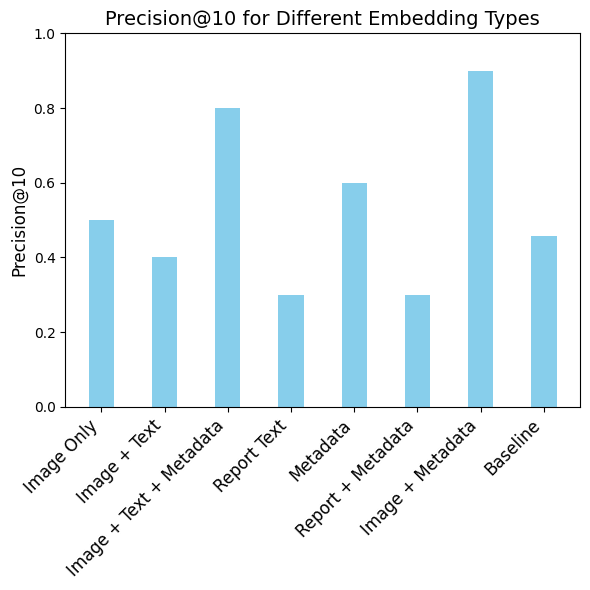

In [286]:



k = 10
precision_values = [
    precision_k_1,
    precision_k_2,
    precision_k_3,
    precision_k_4,
    precision_k_5,
    precision_k_6,
    precision_k_7,
    support_devices_proportion
]

embedding_types = [
    "Image Only",
    "Image + Text",
    "Image + Text + Metadata",
    "Report Text",
    "Metadata",
    "Report + Metadata",
    "Image + Metadata",
    "Baseline"
    
]

plt.figure(figsize=(6, 6))
bars = plt.bar(embedding_types, precision_values, color="skyblue",width=0.4)

# for bar, value in zip(bars, precision_values):
#     plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
#              f"{value:.4f}", ha='center', va='bottom', fontsize=12)

plt.title(f"Precision@{k} for Different Embedding Types", fontsize=14)
plt.ylabel(f"Precision@{k}", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.ylim(0, 1)  
plt.tight_layout()
plt.show()


In [287]:

tokens_slice_1 = analyze_error_slice_tokens(slice_1, test_results, k, max_features)
tokens_slice_2 = analyze_error_slice_tokens(slice_2, test_results, k, max_features)
tokens_slice_3 = analyze_error_slice_tokens(slice_3, test_results, k, max_features)
tokens_slice_4 = analyze_error_slice_tokens(slice_4, test_results, k, max_features)
tokens_slice_5 = analyze_error_slice_tokens(slice_5, test_results, k, max_features)
tokens_slice_6 = analyze_error_slice_tokens(slice_6, test_results, k, max_features)
tokens_slice_7 = analyze_error_slice_tokens(slice_7, test_results, k, max_features)

In [288]:
tokens_slice_1.head()

,token,diff_score,error_count,normal_count
98,catheter,0.131739,7,17
939,unchanged,0.078601,6,41
588,pacemaker,0.067107,2,3
791,removal,0.066225,3,13
651,pneumothorax patient underwent bedside,0.060197,4,22


In [289]:
tokens_slice_2.head()

,token,diff_score,error_count,normal_count
578,op,0.026860,5,0
665,portable,0.023283,51,173
942,tubes,0.021809,5,2
489,lines,0.020634,5,2
39,apparent,0.020138,5,2


In [290]:
tokens_slice_3.head()

,token,diff_score,error_count,normal_count
479,left,0.060076,26,118
936,tube,0.052473,14,52
670,portable,0.046025,31,173
96,catheter,0.042785,7,17
129,chest portable ap,0.042079,14,54


In [291]:
tokens_slice_4.head()

,token,diff_score,error_count,normal_count
470,lead,0.023082,11,4
214,consistent,0.022073,11,9
268,emphysema,0.020622,7,2
940,unchanged,0.020327,20,41
510,mass,0.019509,6,1


In [292]:
tokens_slice_5.head()

,token,diff_score,error_count,normal_count
934,tube,0.053068,26,52
95,catheter,0.028635,11,17
278,esophageal,0.027482,5,1
240,dilation,0.026208,4,1
836,right ij catheter,0.024973,5,3


In [293]:
tokens_slice_6.head()

,token,diff_score,error_count,normal_count
730,radiograph,0.061336,22,55
797,report chest radiograph indication,0.045705,9,9
652,pneumothorax patient underwent bedside,0.045225,12,22
733,radiograph indication,0.044324,9,10
131,chest radiograph indication,0.044324,9,10


In [295]:
tokens_slice_7.head()

,token,diff_score,error_count,normal_count
941,unchanged,0.056437,15,41
159,chest tube,0.043156,8,10
933,tube,0.039882,14,52
209,course,0.039655,4,1
865,similar,0.037633,4,1
